# 'Binary Only' scRNA-seq Workflow

This notbook outlines the workflow for preprocessing and binarization of a single-cell rna-seq (scRNA-seq) dataset provided as an anndata object compatible with Scanpy. Preprocessing and QC are based on typical parameters for scRNA-seq analyses in Scanpy.

In [1]:
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
import scanpy as sc
import pandas as pd
import numpy as np
import anndata
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk

from sklearn.metrics import adjusted_rand_score


In [2]:
import rpy2
%load_ext rpy2.ipython

In [3]:
# set folder to save figures and set a prefix for figure names

figdir = './figure_S2/'
prefix = 'figure_S2_'


In [4]:
# set default plot size and dpi for all plots in notebook

sc.settings.set_figure_params(dpi=300, dpi_save=300, vector_friendly=True, fontsize=12, figsize=(4, 4))
sc.settings.figdir = figdir
sc.settings._file_format_figs = 'svg'

In [38]:
sns.set_context('paper', font_scale=1.5)

In [18]:
plt.rcParams["axes.grid"] = False

'preprocess_adata' defines a function that takes an anndata object and returns a preprocessed anndata object.

The function performs the following steps:
    
        - log transform the data
        - regress out the effect of the number of genes expressed per cell
        - regress out the effect of the percentage of mitochondrial/ribosomal/hemoglobin genes expressed per cell
        - calculate highly variable genes
       
If the 'binary' parameter is set to True, the function will also binarize the data by setting all values above 0 to 1.

If 'binary' is set to False, the function will also perform the following steps:
        
           - normalize to 10,000 counts per cell
           - log transform the data
           - scale the data to unit variance

The function returns the preprocessed anndata object.

In [9]:
def preprocess_adata(adata, binary=False, min_genes=200, min_cells=3, mt_pattern='MT-', ribo_pattern=("RPS", "RPL"), hb_pattern="^HB[^(P)]"):
    if not isinstance(adata, anndata.AnnData):
        raise ValueError("Input is not a valid AnnData object")

    adata = adata.copy()
    adata.var_names_make_unique()
    adata.obs_names_make_unique()

    # Define mitochondrial, ribosomal, and hemoglobin genes
    adata.var['mt'] = adata.var_names.str.startswith(mt_pattern)
    adata.var['ribo'] = adata.var_names.str.startswith(ribo_pattern)
    adata.var['hb'] = adata.var_names.str.contains(hb_pattern)

    # Calculate QC metrics
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt', 'ribo', 'hb'], percent_top=None, log1p=False, inplace=True)

    # Filter cells and genes
    sc.pp.filter_cells(adata, min_genes=min_genes)
    sc.pp.filter_genes(adata, min_cells=min_cells)

    # Additional quality control based on QC metrics
    adata = adata[adata.obs['pct_counts_mt'] < 20, :]  # Filter based on mitochondrial content
    #adata = adata[adata.obs['pct_counts_ribo'] > 5, :]  # Filter based on ribosomal content

    if binary:
        adata.X = (adata.X > 0).astype(np.int8)
        adata.raw = adata
        sc.pp.highly_variable_genes(adata)
    else:
        adata.raw = adata
        sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
        sc.pp.log1p(adata)
        sc.pp.highly_variable_genes(adata)
        sc.pp.scale(adata, max_value=10)

    return adata[:, adata.var.highly_variable]


'parser_standard' defines a function that accepts as input an anndata object, and returns a dictionary of processed prebinary and binary versions of the anndata. If the 'batch_key' parameter is set, batch correction is performed using bbknn.

The function also performs PCA dimensionality reduction, neighborhood graph construction, and Leiden clustering. The resolution hyperparameter for Leiden clustering may be adjusted from the default '1' via the 'resolution' parameter.

In [10]:
def parser_standard(adata, batch_key=None, resolution=1):
    result_dict = {}
    adata_prebinary = preprocess_adata(adata)
    adata_bin = preprocess_adata(adata, binary=True)

    for adata_processed, key in zip([adata_prebinary, adata_bin], ['Prebinary', 'Binary']):
        # Perform downstream analysis steps
        if key != 'Binary':
            # Regress out effects of total counts and potentially other confounders
            sc.pp.regress_out(adata_processed, ['total_counts', 'pct_counts_mt', 'pct_counts_ribo'])

            # Scale the data for non-binary analysis
            sc.pp.scale(adata_processed, max_value=10)

        # Dimensionality reduction and clustering
        sc.tl.pca(adata_processed, svd_solver='arpack')
        if batch_key is not None:
            sc.external.pp.bbknn(adata_processed, batch_key=batch_key)
        else:
            sc.pp.neighbors(adata_processed)
        sc.tl.umap(adata_processed)
        sc.tl.leiden(adata_processed, resolution=resolution, key_added=f'{key}_cluster')

    
        # Store the results
        result_dict[key] = adata_processed

    # Share the binary cluster labels with the prebinary data
    result_dict['Prebinary'].obs['Binary_cluster'] = result_dict['Binary'].obs['Binary_cluster']

    return result_dict


## PBMC3k Dataset

In [51]:
# importing pbmc3k raw data

pbmc_file = sc.read('pbmc_file.h5ad')

In [58]:
pbmc_file

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

In [52]:
# Importing annotated pbmc3k data as reference

pbmc3k_standard = sc.read_h5ad('pbmc3k_standard.h5ad')

In [53]:
pbmc_result = parser_standard(pbmc_file)

In [55]:
pbmc_prebinary = pbmc_result['Prebinary']
pbmc_binary = pbmc_result['Binary']
pbmc_prebinary.obs['cell_type'] = pbmc3k_standard.obs['cell_type'].astype('category')
pbmc_binary.obs['cell_type'] = pbmc3k_standard.obs['cell_type'].astype('category')

In [54]:
pbmc_result

{'Prebinary': AnnData object with n_obs × n_vars = 2698 × 1865
     obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'n_genes', 'n_counts', 'Prebinary_cluster', 'Binary_cluster'
     var: 'gene_ids', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
     uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden'
     obsm: 'X_pca', 'X_umap'
     varm: 'PCs'
     obsp: 'distances', 'connectivities',
 'Binary': AnnData object with n_obs × n_vars = 2698 × 2047
     obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'n_genes', 'Binary_cluster'
     var: 'gene_ids', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_co

In [56]:
# drop cells in prebinary & binary data that are not in pbmc3k_standard

pbmc_prebinary = pbmc_prebinary[pbmc_prebinary.obs.index.isin(pbmc3k_standard.obs.index)]
pbmc_binary = pbmc_binary[pbmc_binary.obs.index.isin(pbmc3k_standard.obs.index)]

/usr/local/Caskroom/miniconda/base/envs/muon_compat/lib/python3.11/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/usr/local/Caskroom/miniconda/base/envs/muon_compat/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


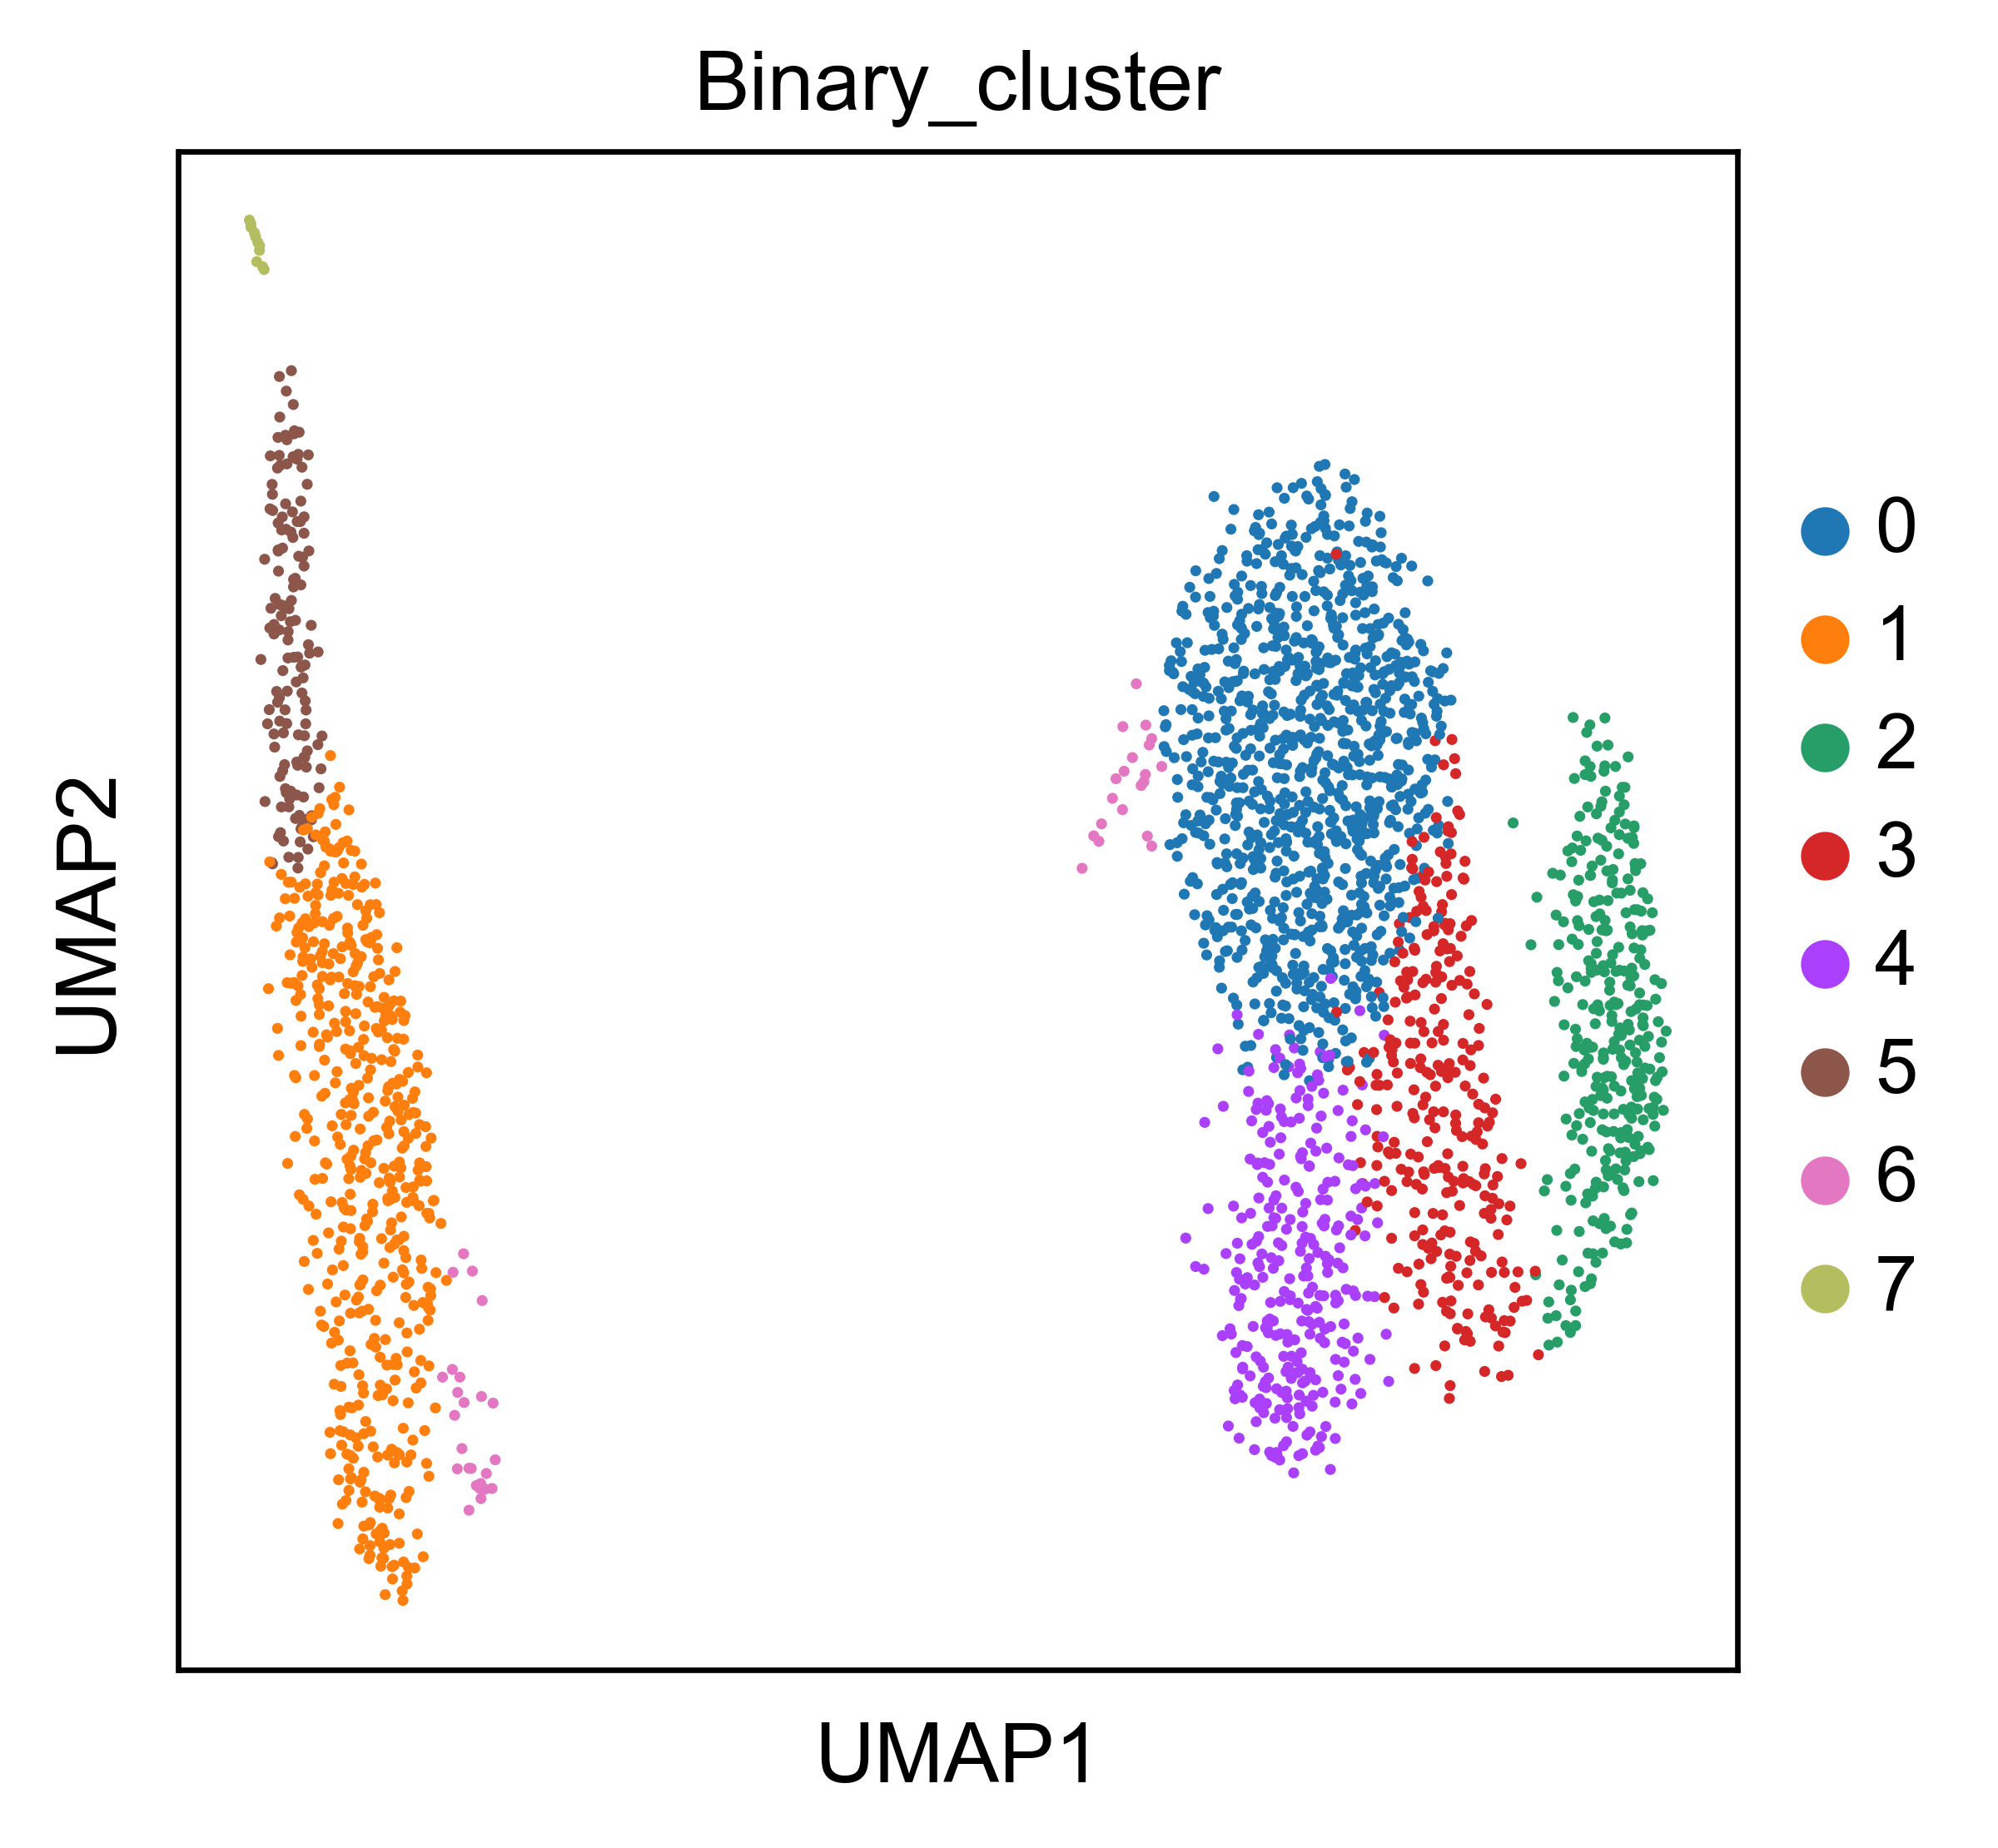

In [57]:
sc.pl.umap(pbmc_binary, color=['Binary_cluster'], size=10, save=f'{prefix}a2.svg')

In [14]:
pbmc3k_markers = {'B': ['MS4A1', 'CD79A'],   
                'CD4 T': ['IL7R', 'CCR7'],
                'CD8 T': ['CD8A'],
                'CD14 Monocytes': ['CD14'],
                'Dendritic': ['FCER1A', 'CD1C'],
                'FCG3A Monocytes': ['FCGR3A', 'MS4A7'], 
                'Megakaryocytes': ['PPBP', 'PF4'],
                'NK': ['GNLY', 'NKG7'],}

/usr/local/Caskroom/miniconda/base/envs/muon_compat/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


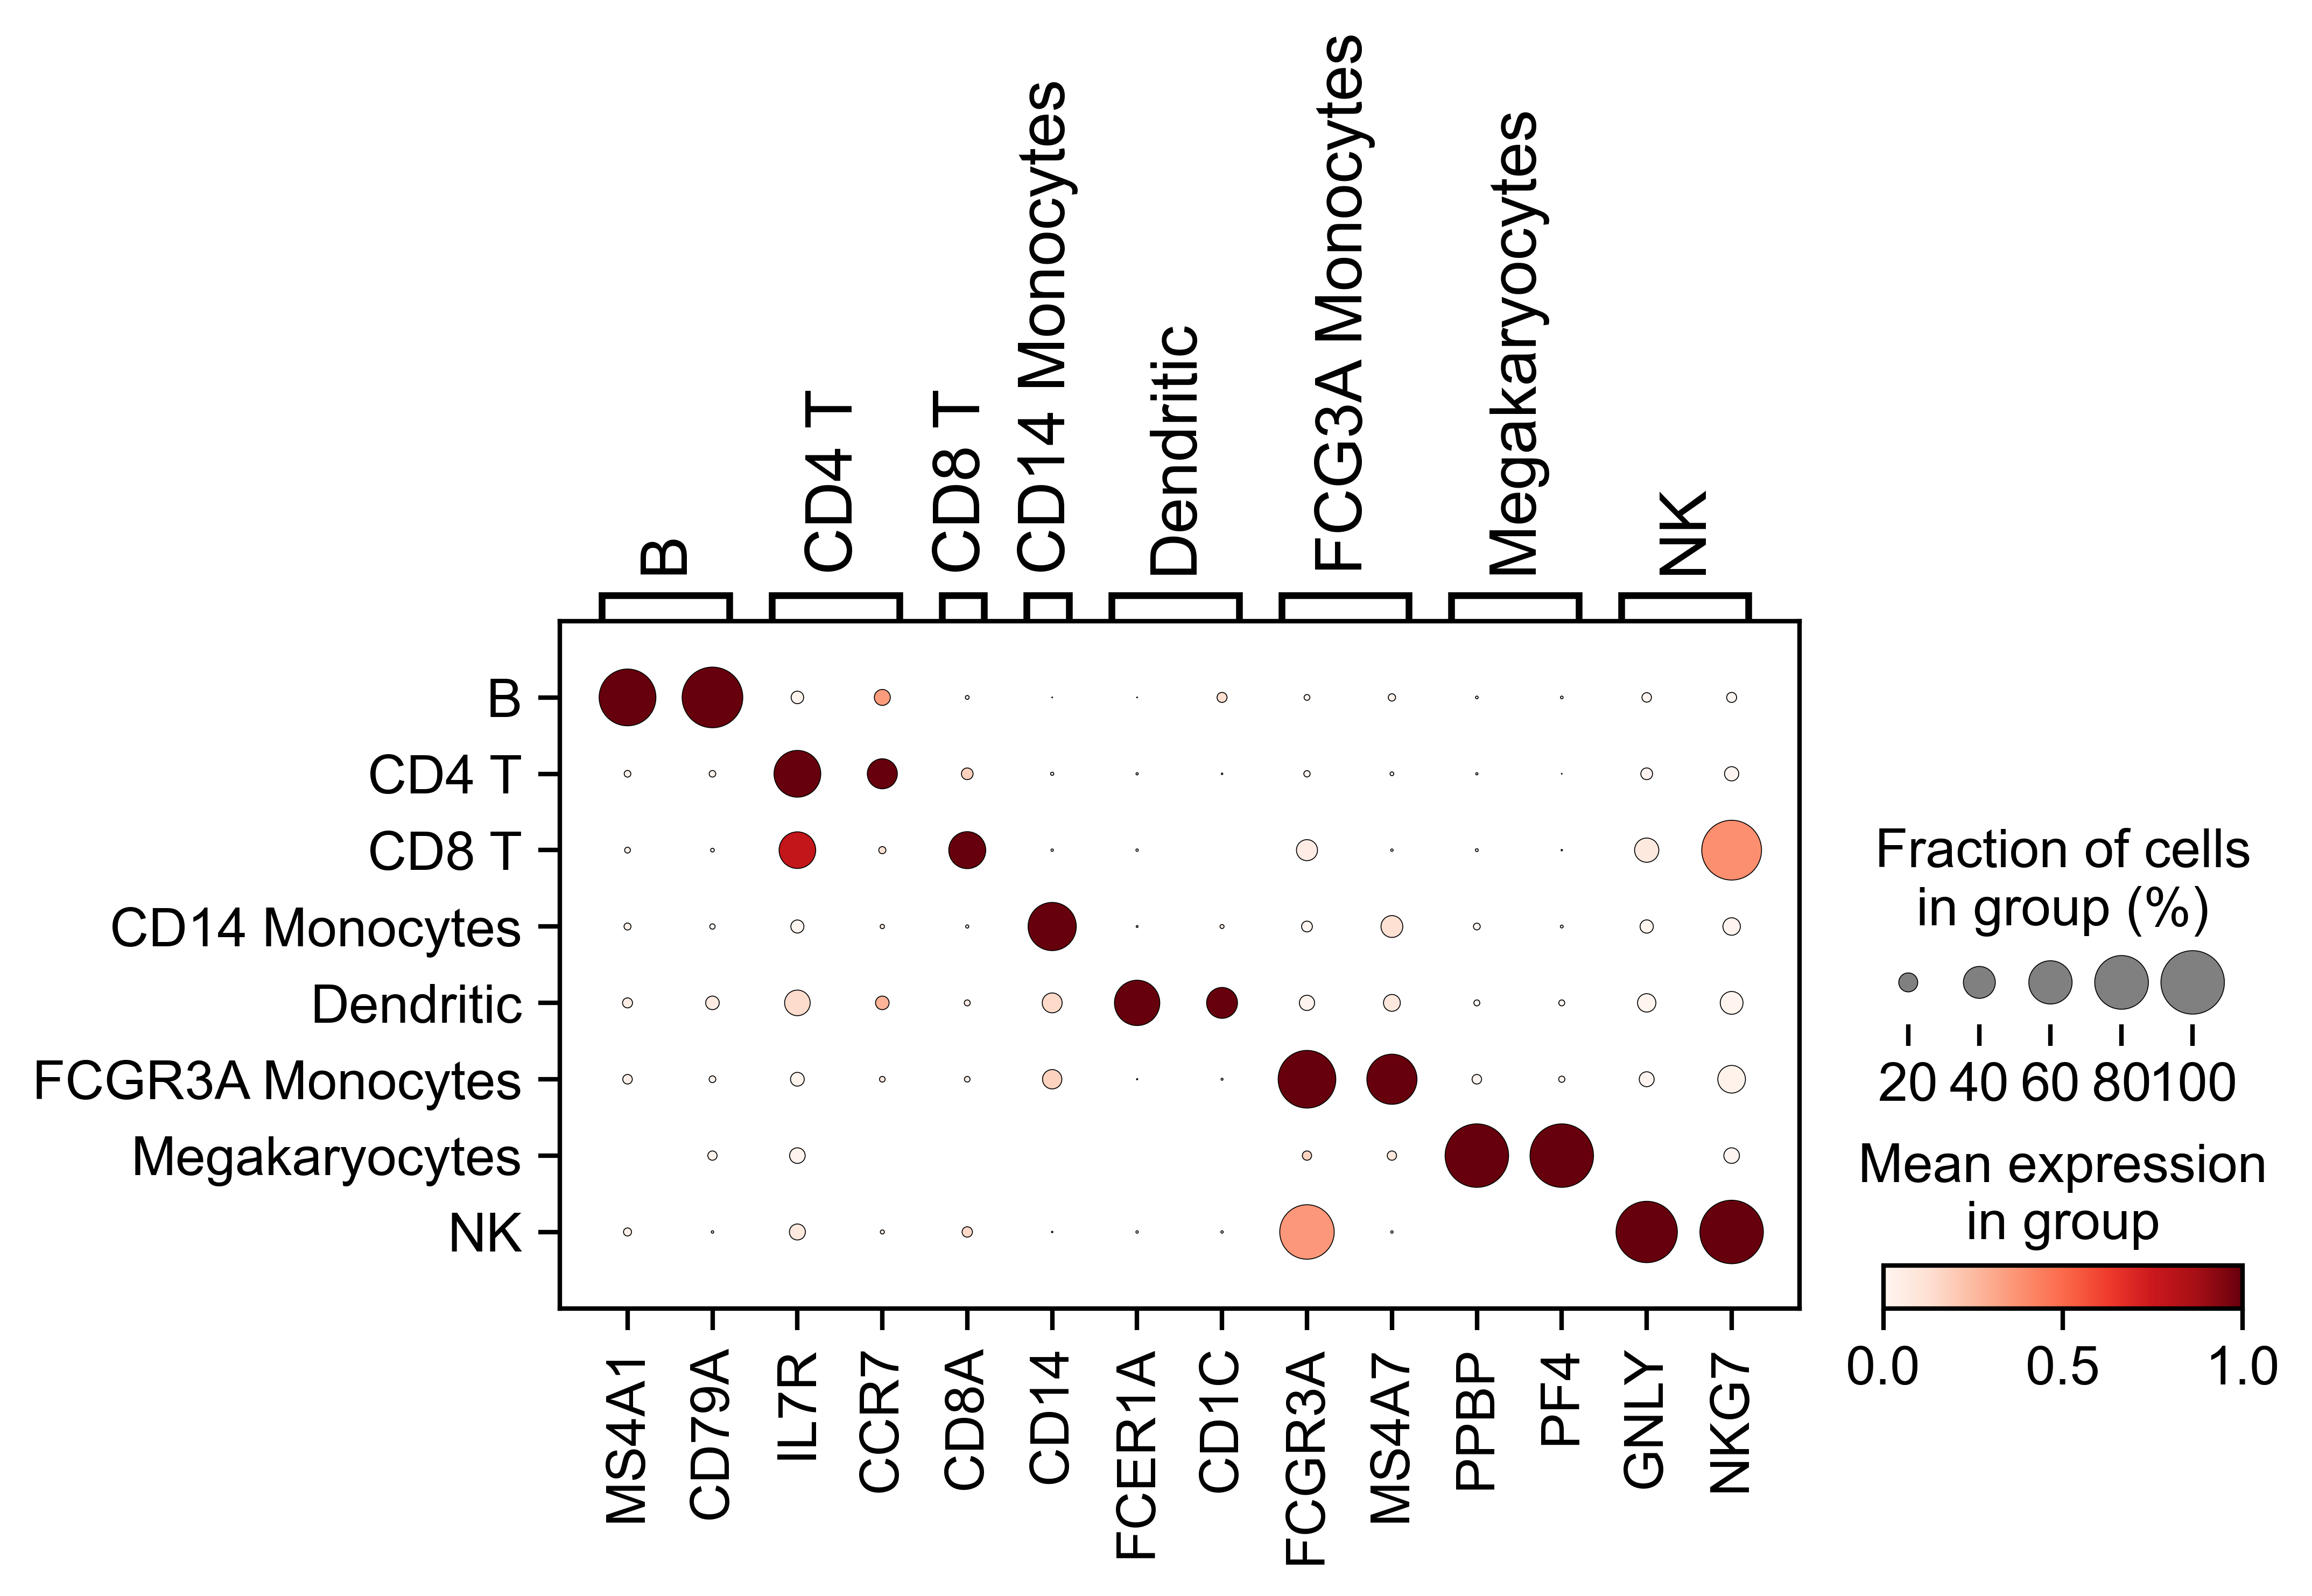

In [47]:
sc.pl.dotplot(pbmc_prebinary, pbmc3k_markers, groupby='cell_type', standard_scale='var', save=f'{prefix}celltype.svg')

In [16]:
# Annotated heatmap of cell type vs cluster

def create_annotated_heatmap(df, col1, col2):
    # Create a crosstab between the specified columns
    crosstab = pd.crosstab(df[col1], df[col2])

    # normalize each column by its maximum

    normalized_crosstab = crosstab.div(crosstab.max(axis=0), axis=1)

    # Create the heatmap
    plt.figure(figsize=(10, 8))  # Optional: Adjust the size as needed
    return sns.heatmap(normalized_crosstab, cmap='Blues', annot=crosstab, fmt='g', 
                linewidths=.5, linecolor='black').set_title(f'{col1} vs. {col2}')



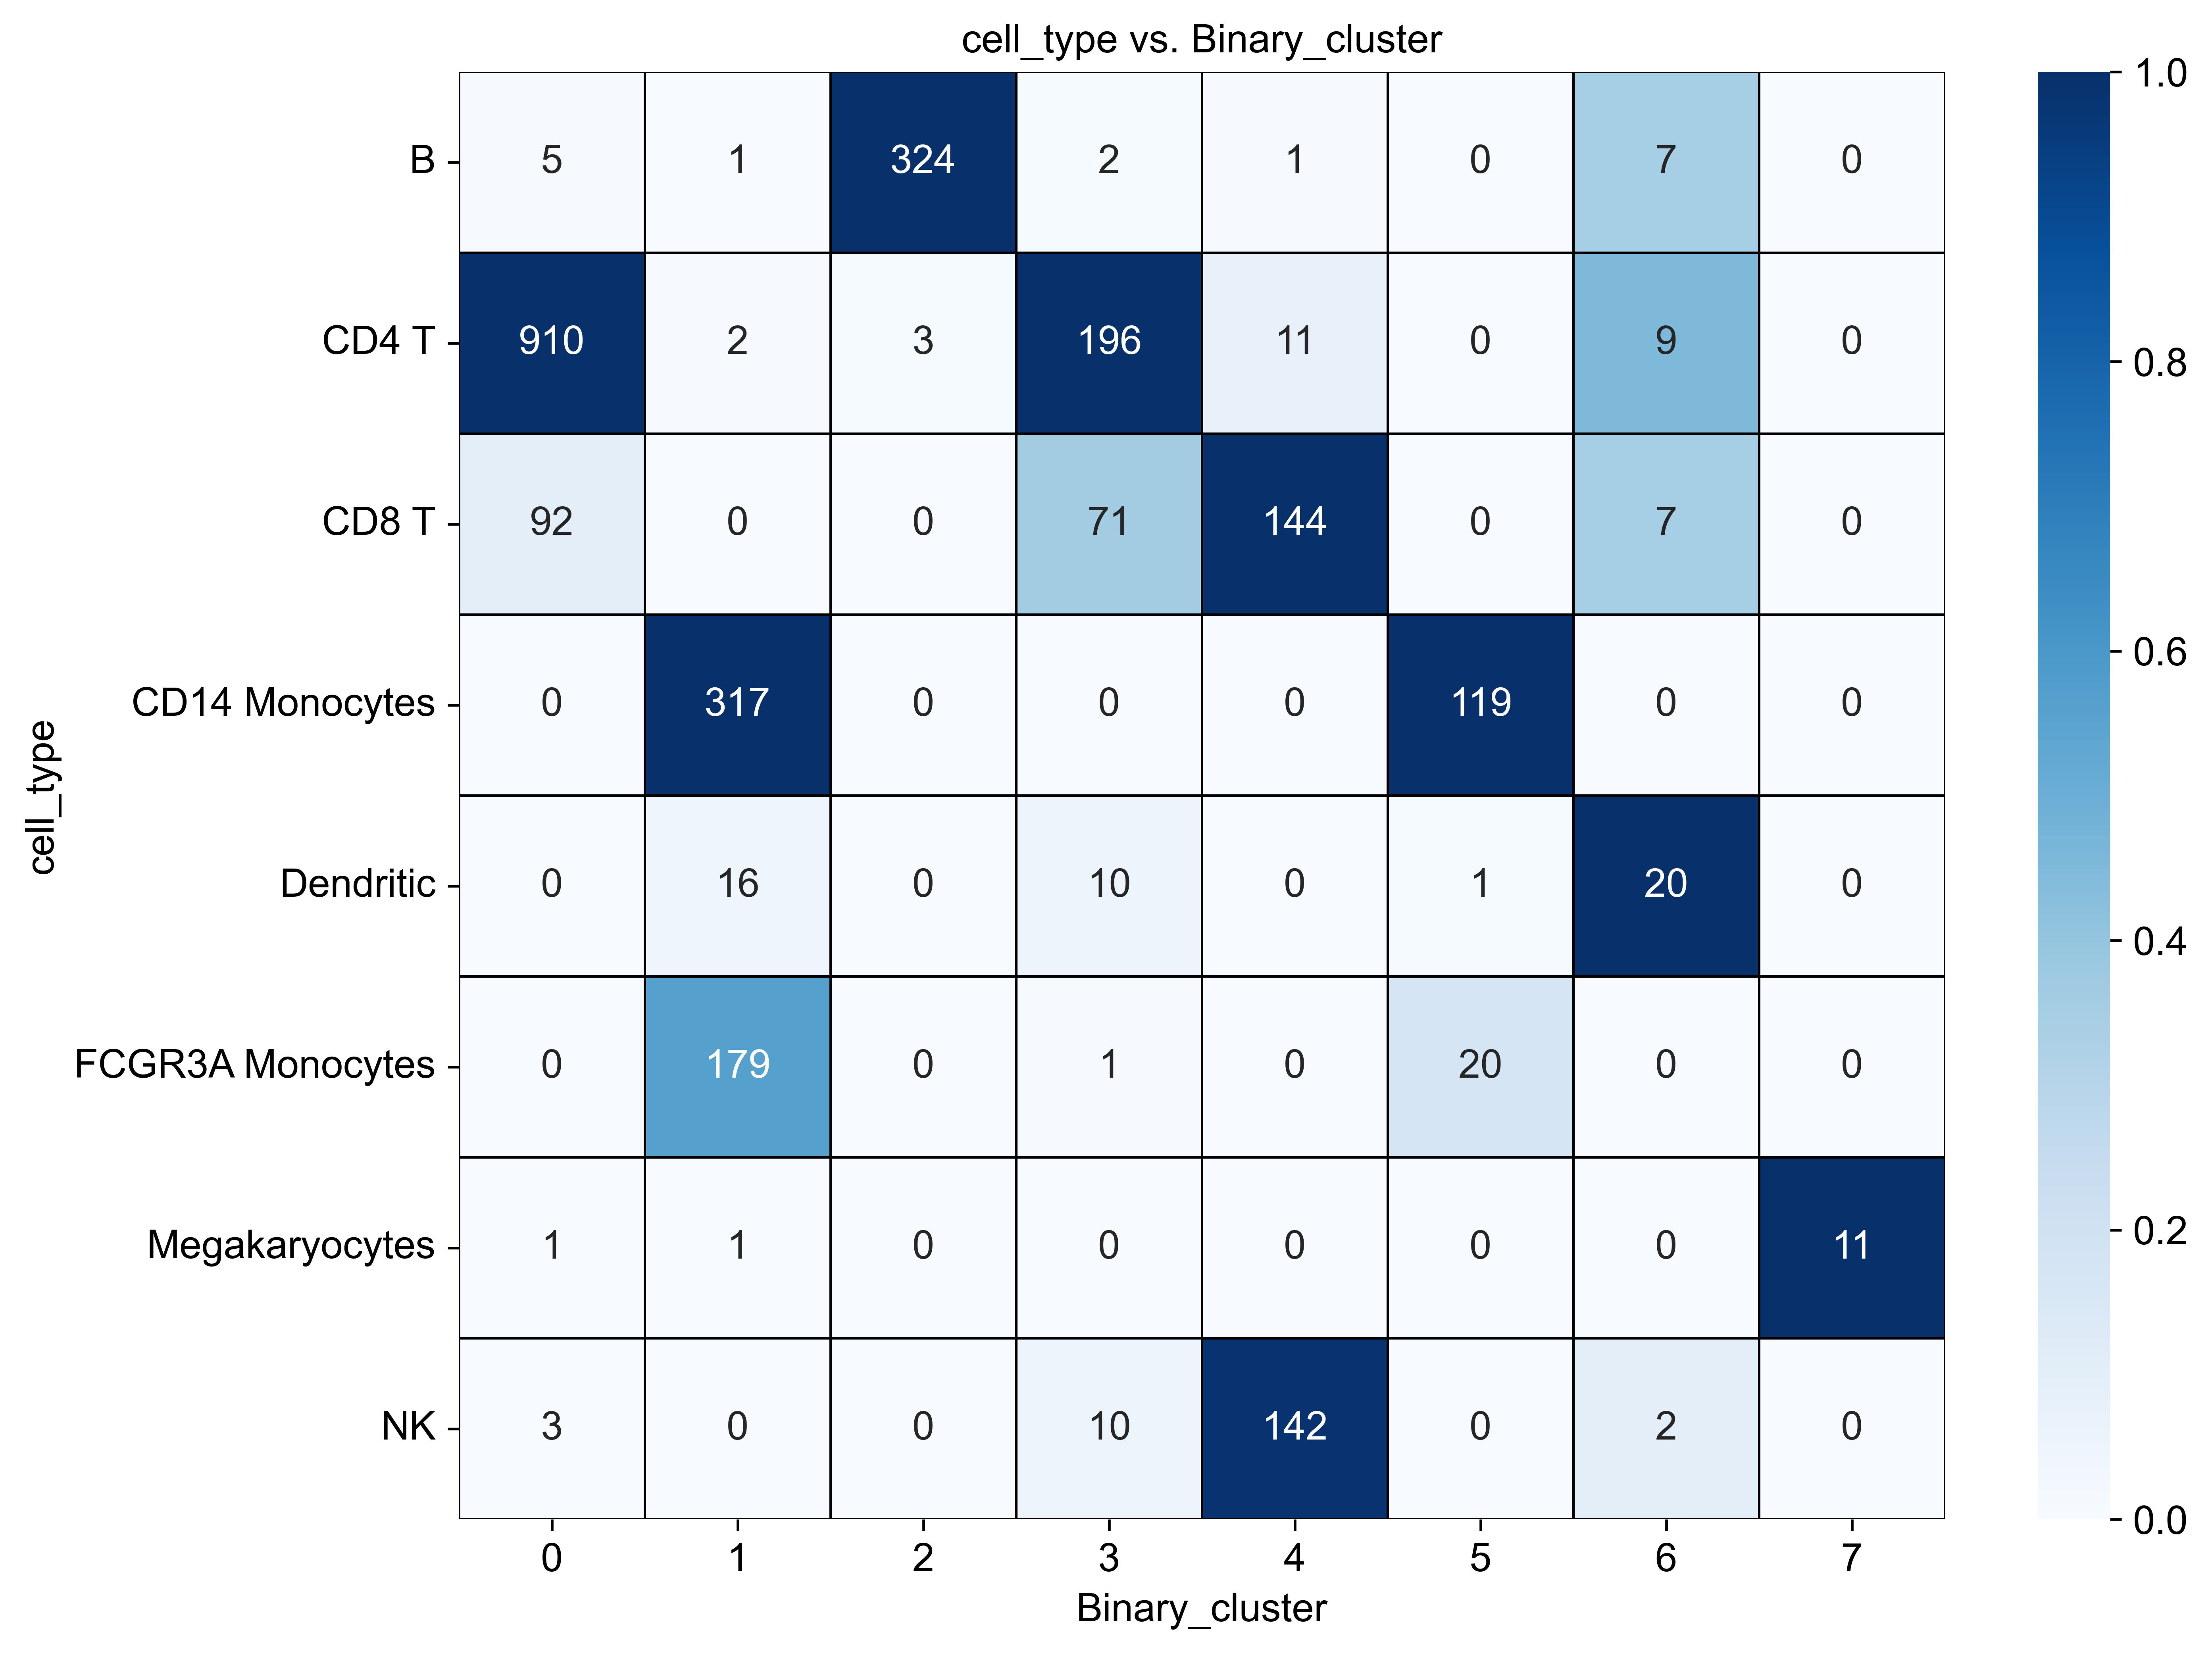

In [17]:
heatmap_fig = create_annotated_heatmap(pbmc_binary.obs, 'cell_type', 'Binary_cluster')

In [18]:
heatmap_fig.get_figure().savefig(f'{figdir}{prefix}c.svg', dpi=300, bbox_inches='tight')

In [19]:
pbmc_binary

AnnData object with n_obs × n_vars = 2638 × 2047
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'n_genes', 'Binary_cluster', 'cell_type'
    var: 'gene_ids', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'Binary_cluster_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [36]:
def cluster_accuracy(adata):
    crosstab = pd.crosstab(adata.obs['Binary_cluster'], adata.obs['Cell_Type'])
    accuracy = crosstab.max(axis=1)/crosstab.sum(axis=1)
    return accuracy

In [40]:
pan_binary = pan_result['Binary']

In [25]:
pbmc_crosstab = pd.crosstab(pbmc_binary.obs['Binary_cluster'], pbmc_binary.obs['cell_type'])

In [41]:
pan_crosstab = pd.crosstab(pan_binary.obs['Binary_cluster'], pan_binary.obs['Cell_Type'])

In [47]:
# from pbmc_crosstab, add up all cells that are in column max for all, and give it as a percentage of the matrix total 

pbmc_crosstab.max(axis=1).sum()/pbmc_crosstab.sum().sum()

0.7736921910538287

In [50]:
# from pbmc_crosstab, add up all cells that are in column max for all, and give it as a percentage of the matrix total 

pan_crosstab.max(axis=1).sum()/pbmc_crosstab.sum().sum()

0.7414708112206216

In [24]:
# using the function above, calculate the accuracy of each cluster, give an average and the range 

cluster_accuracy(pbmc_binary).mean()

0.7448492094041361

In [28]:
cluster_accuracy(pbmc_binary).sort_values()

Binary_cluster
6    0.444444
4    0.483221
1    0.614341
3    0.675862
5    0.850000
0    0.900099
2    0.990826
7    1.000000
dtype: float64

In [37]:
cluster_accuracy(pan_result['Binary']).sort_values()

Binary_cluster
10    0.454545
12    0.555556
3     0.656250
13    0.688312
9     0.702970
8     0.876923
7     0.933824
11    0.964286
6     0.972603
4     0.985507
5     0.993548
1     0.995885
0     0.996743
2     1.000000
dtype: float64

# Pancreatic Data

In [29]:
# pancreatic data

pancreatic_metadata = pd.read_table('E-MTAB-5061.sdrf.txt', index_col=0)
pancreatic_data = sc.read('pancreas_data_flip_tpm.txt')

/usr/local/Caskroom/miniconda/base/envs/muon_compat/lib/python3.11/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [30]:
# pancreatic specific metadata

pancreatic_data.obs["Individual"] = pancreatic_metadata['Characteristics[individual]']        
pancreatic_data.obs['Cell_Type'] = pancreatic_metadata['Factor Value[cell type]']
pancreatic_data = pancreatic_data[~pancreatic_data.obs.Cell_Type.isin(["not applicable"])]
pancreatic_data.obs['Condition'] = pancreatic_metadata['Factor Value[disease]']

/var/folders/xj/p_ddg_256k37zv0c7cy37hb40000gn/T/ipykernel_23844/945338462.py:6: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  pancreatic_data.obs['Condition'] = pancreatic_metadata['Factor Value[disease]']
/usr/local/Caskroom/miniconda/base/envs/muon_compat/lib/python3.11/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/Caskroom/miniconda/base/envs/muon_compat/lib/python3.11/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [31]:
pancreatic_data

AnnData object with n_obs × n_vars = 2209 × 26178
    obs: 'Individual', 'Cell_Type', 'Condition'

In [32]:
pan_result = parser_standard(pancreatic_data, batch_key='Individual', resolution=1.5)

/usr/local/Caskroom/miniconda/base/envs/muon_compat/lib/python3.11/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/Caskroom/miniconda/base/envs/muon_compat/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:208: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)
/usr/local/Caskroom/miniconda/base/envs/muon_compat/lib/python3.11/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/usr/local/Caskroom/miniconda/base/envs/muon_compat/lib/python3.11/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/usr/local/Caskroom/miniconda/base/envs/muon_compat/lib/python3.11/site-packages/annd

In [33]:
pan_result

{'Prebinary': AnnData object with n_obs × n_vars = 2209 × 3977
     obs: 'Individual', 'Cell_Type', 'Condition', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'n_genes', 'n_counts', 'Prebinary_cluster', 'Binary_cluster'
     var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
     uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden'
     obsm: 'X_pca', 'X_umap'
     varm: 'PCs'
     obsp: 'distances', 'connectivities',
 'Binary': AnnData object with n_obs × n_vars = 2209 × 5492
     obs: 'Individual', 'Cell_Type', 'Condition', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'n_genes', 'Binary_cluster'
     var: 'mt', 'ribo', 'hb', 'n_cells_by_co

/usr/local/Caskroom/miniconda/base/envs/muon_compat/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


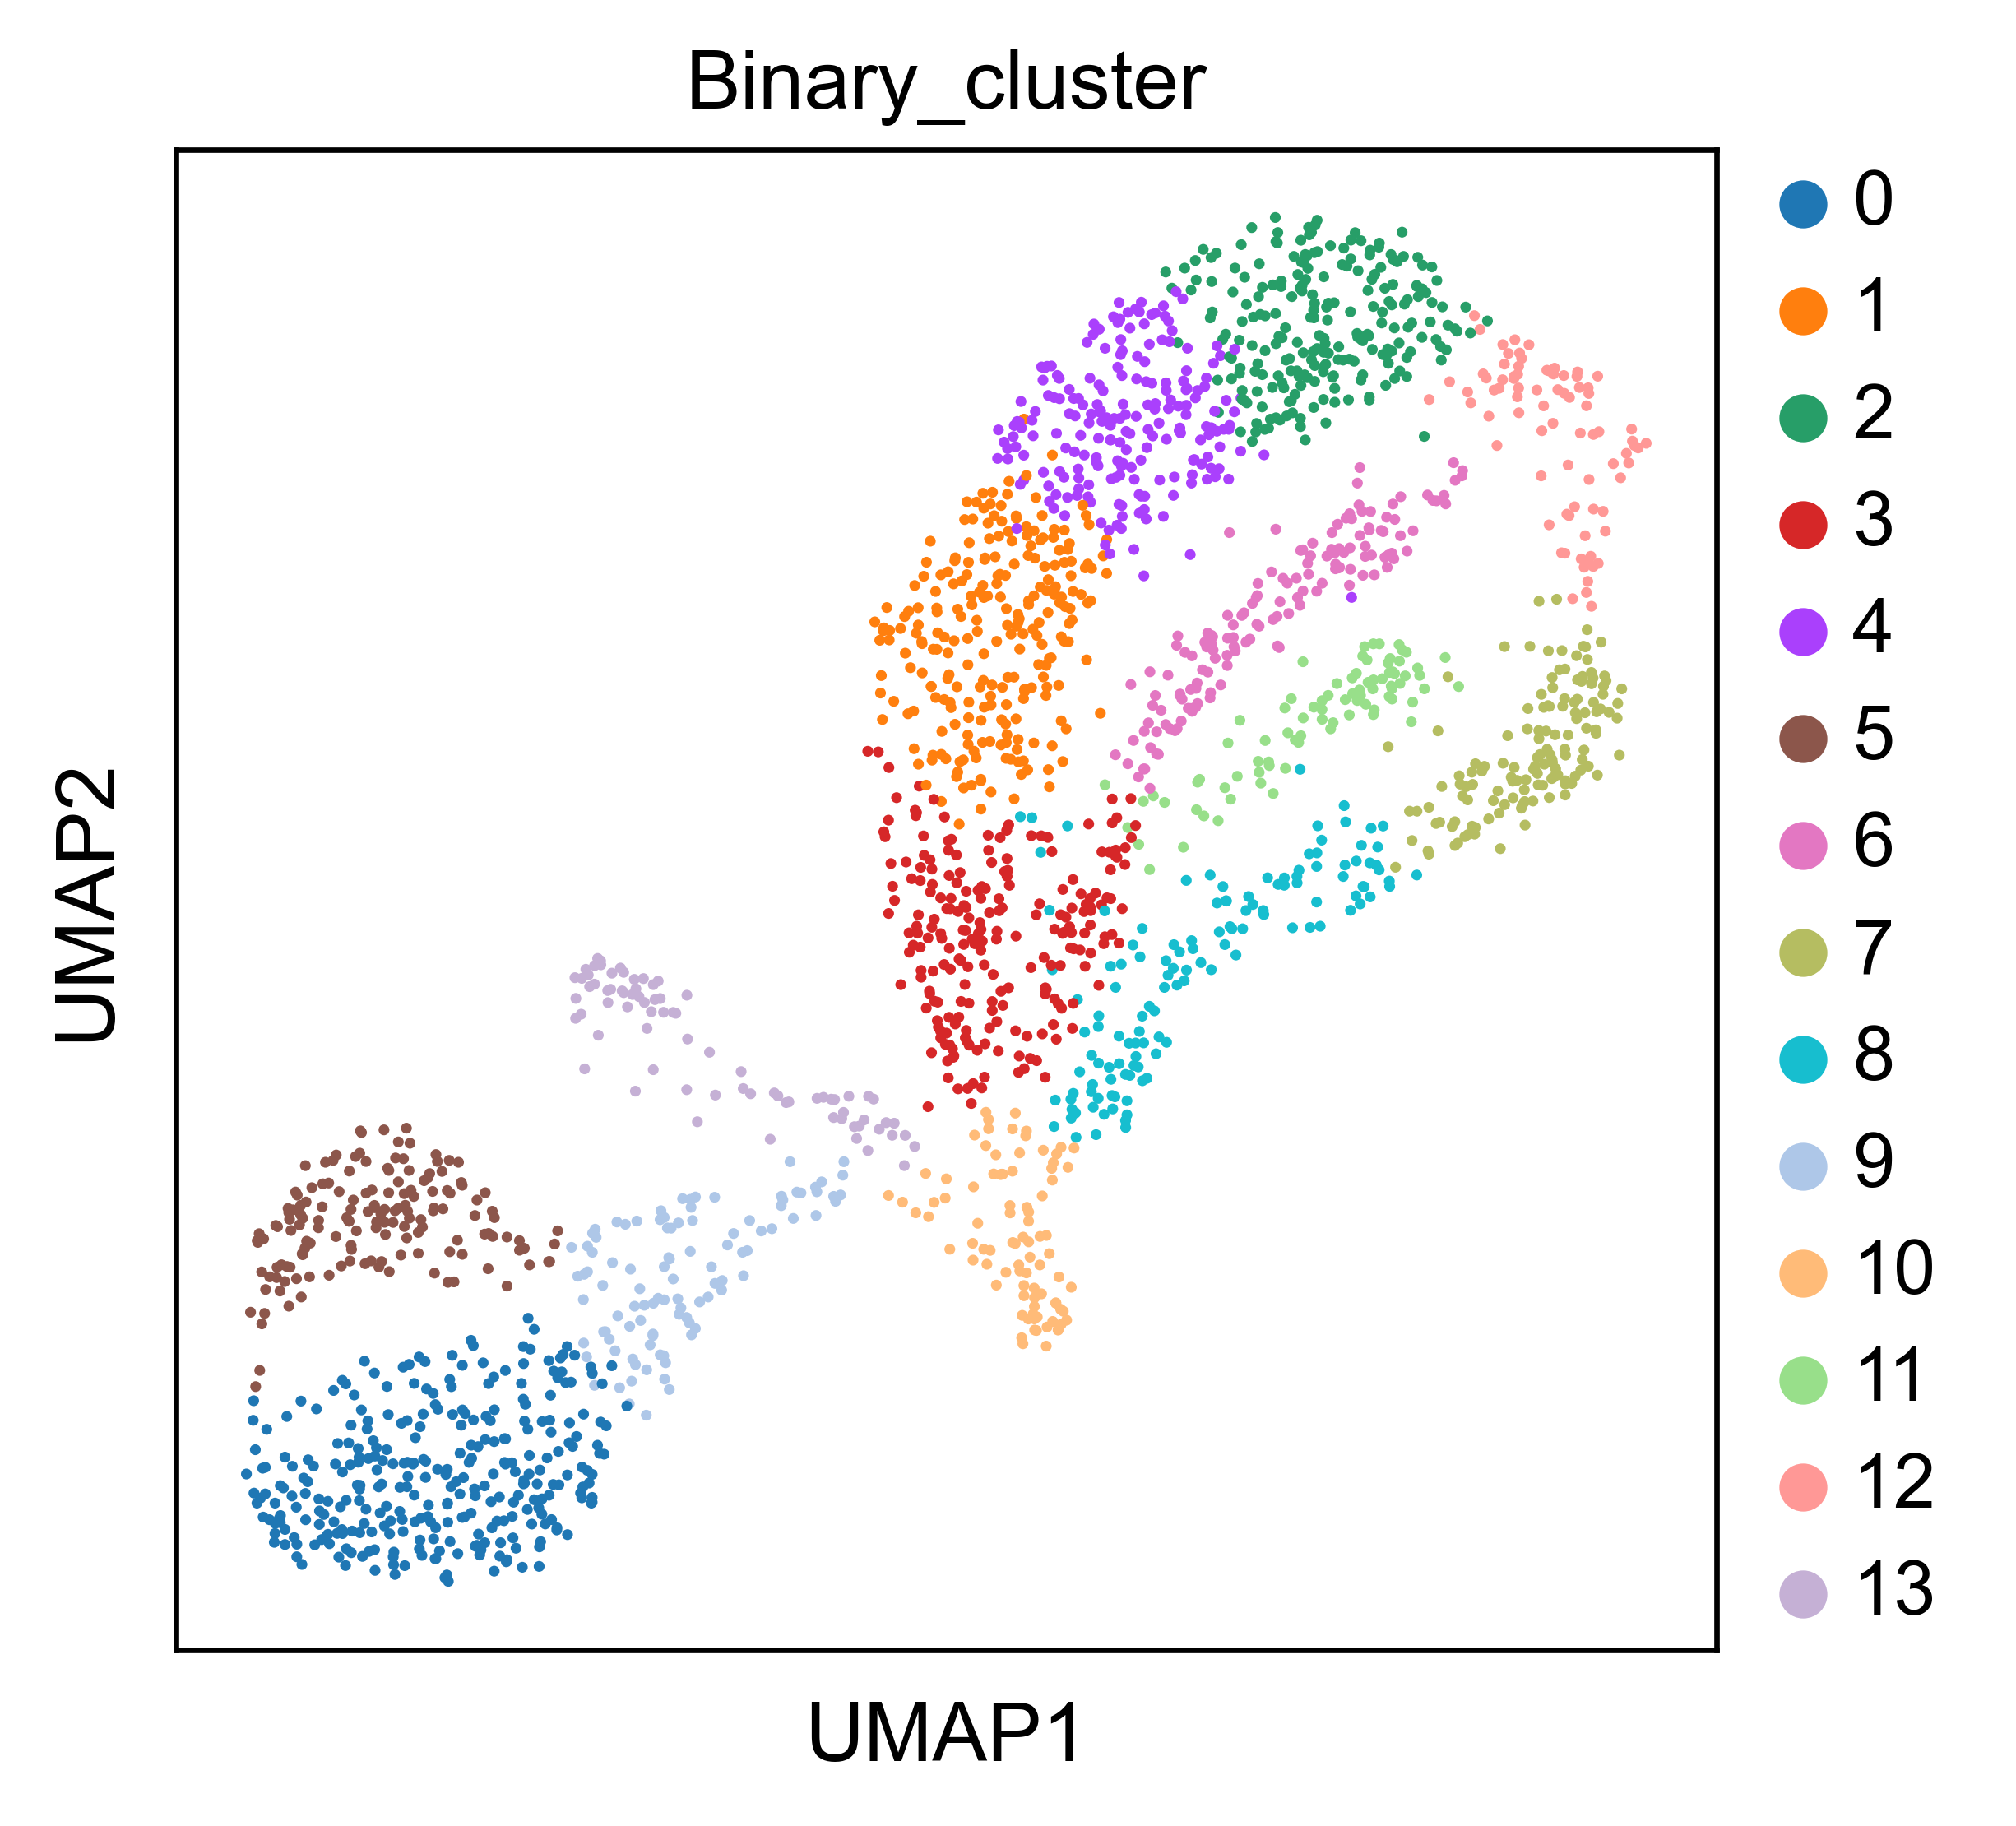

In [34]:
sc.pl.umap(pan_result['Binary'], color=['Binary_cluster'], size=10, save=f'{prefix}d2.svg')

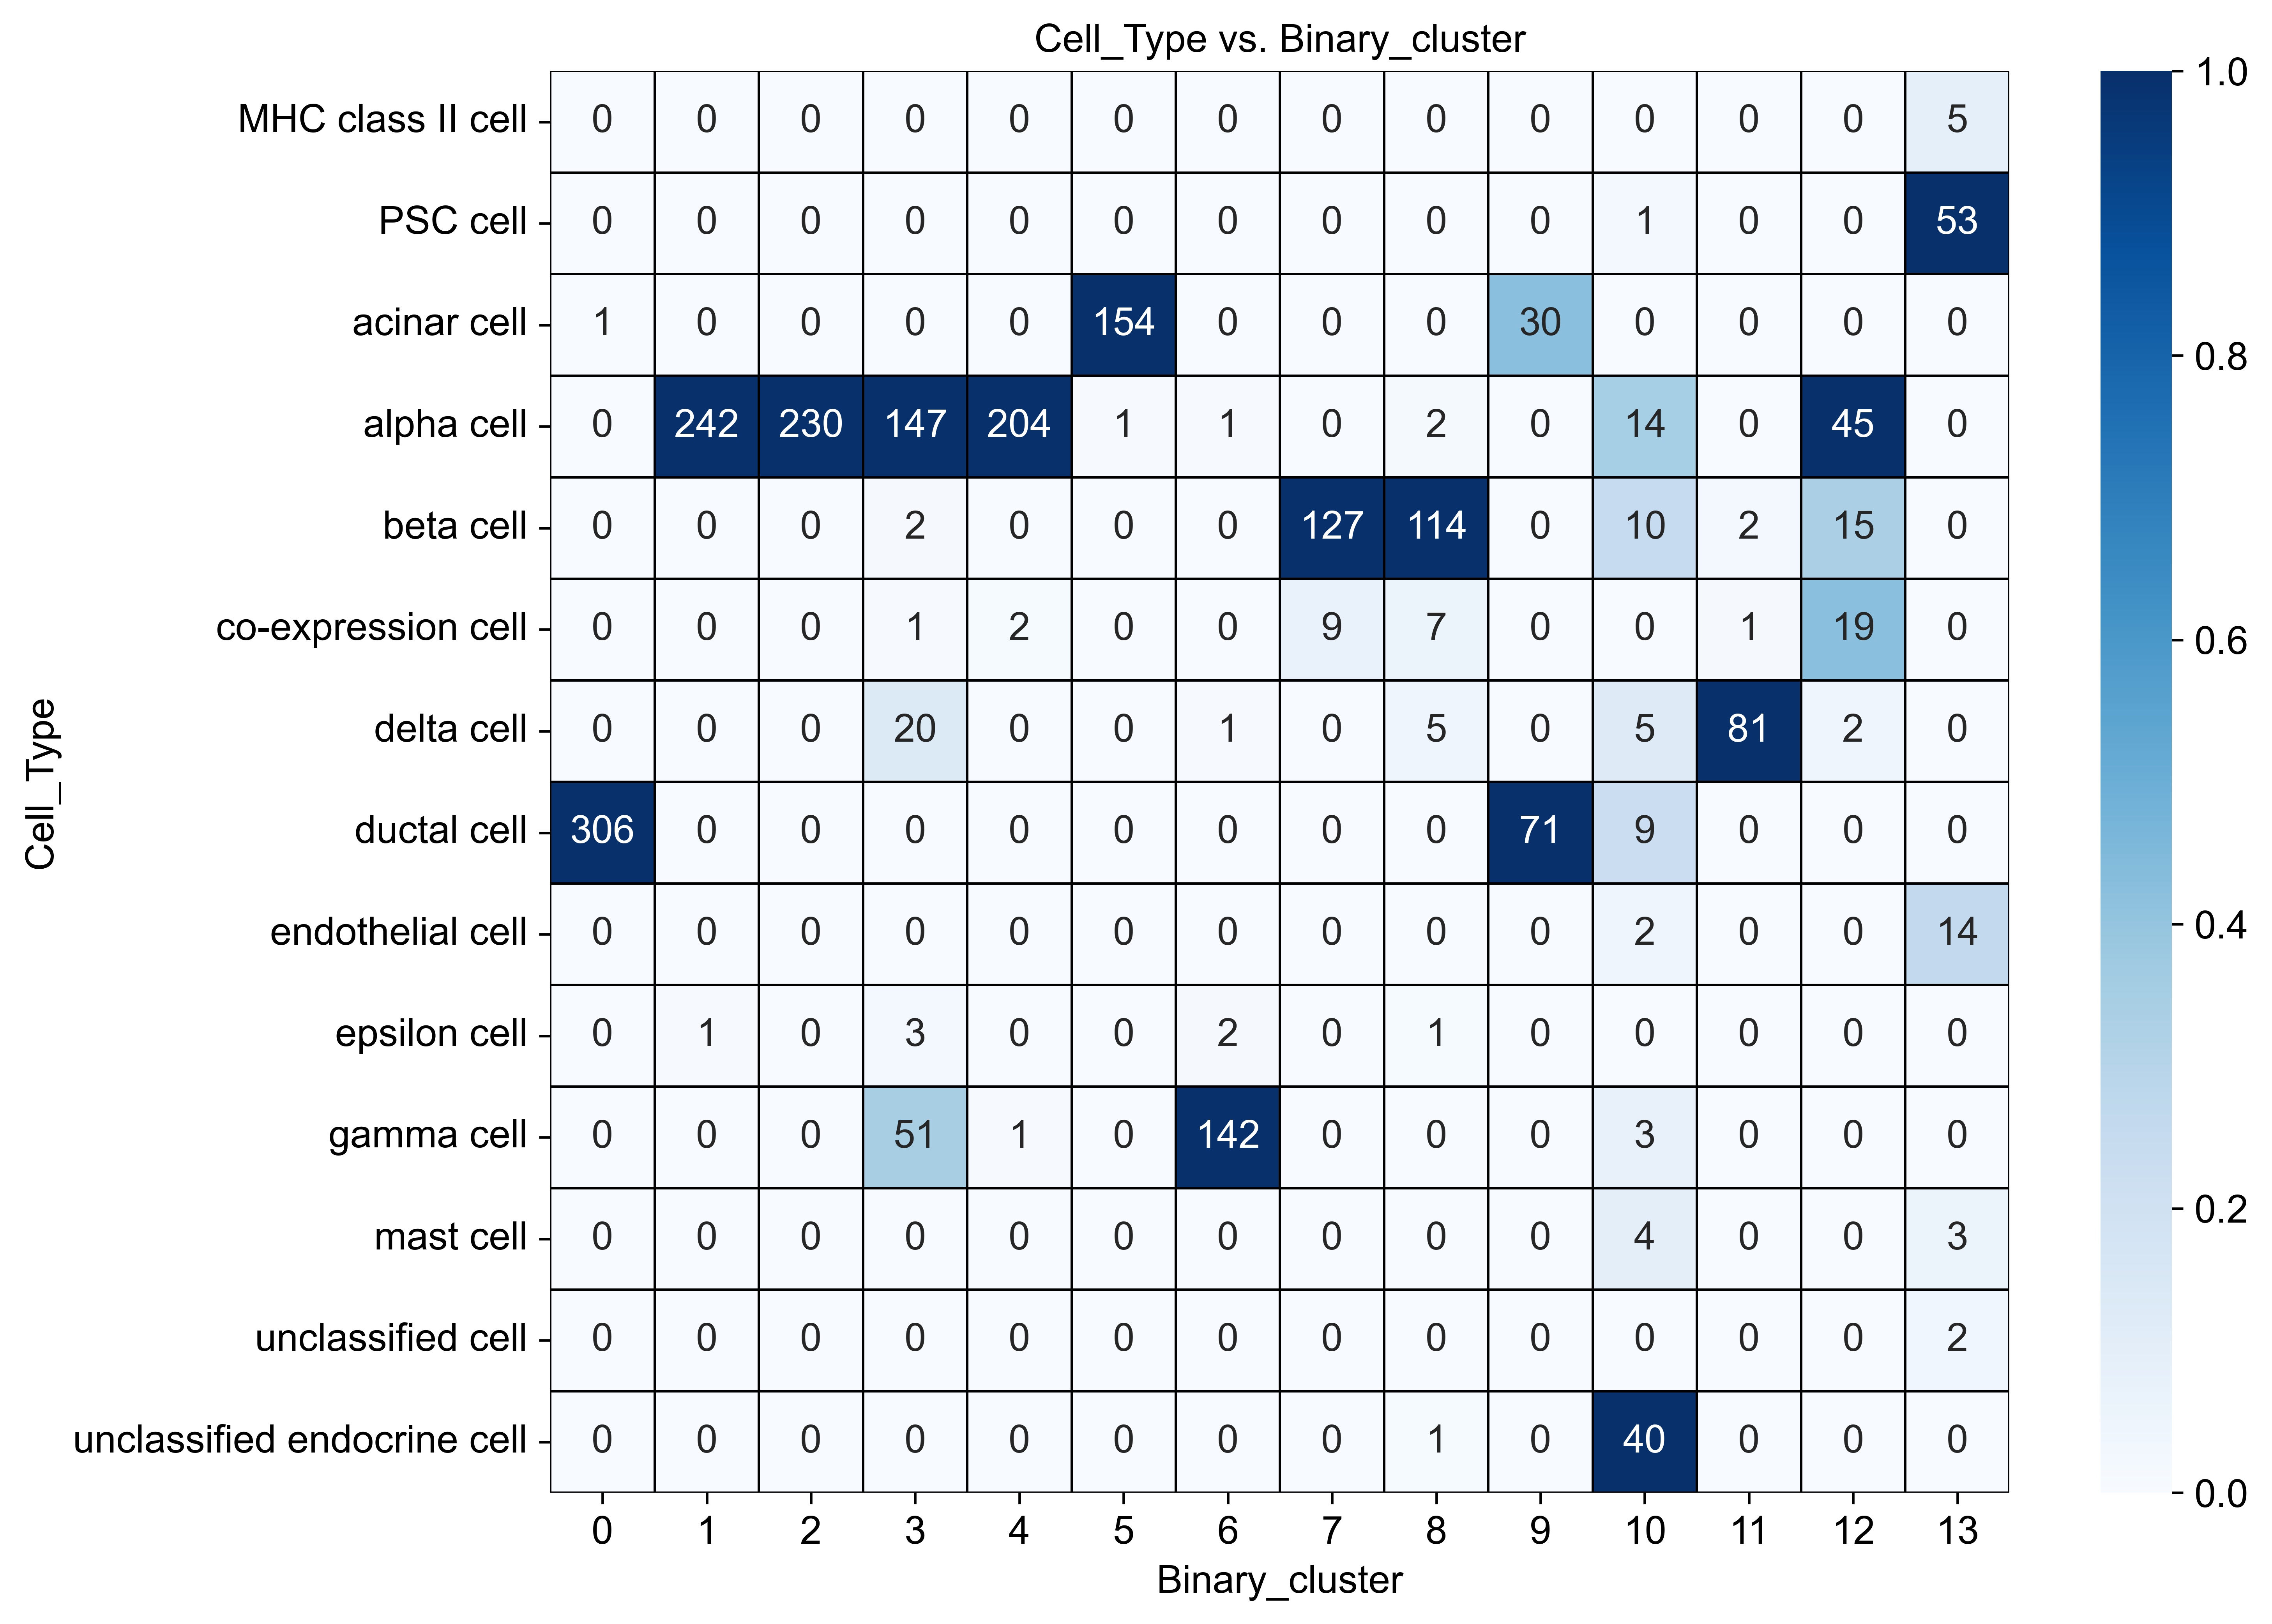

In [44]:
pan_bin_heatmap = create_annotated_heatmap(pan_result['Binary'].obs, 'Cell_Type', 'Binary_cluster')

In [45]:
pan_bin_heatmap.get_figure().savefig(f'{figdir}{prefix}e2.svg', dpi=300, bbox_inches='tight')

In [29]:

pan_markers = {'MHC class II cell': ['CD86', 'HLA-DPA1'],
               'PSC cell': ['ACTA2', 'FN1'],
               'acinar cell': ['PRSS1'],
               'alpha cell': ['DPP4', 'GPR119'],
               'beta cell': ['INS', 'LINC01099'],
               'delta cell': ['LEPR', 'GHSR'],
               'ductal cell': ['KRT19'],
               'endothelial cell': ['PLVAP', 'PECAM1'],
               'epsilon cell': ['GHRL', 'GHRLOS'],
               'gamma cell': ['SERTM1', 'PPY'],
               'mast cell': ['TPSAB1', 'TPSB2'],
               'unclassified endocrine cell': ['RCAN1', 'NOV']
               }


/usr/local/Caskroom/miniconda/base/envs/muon_compat/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


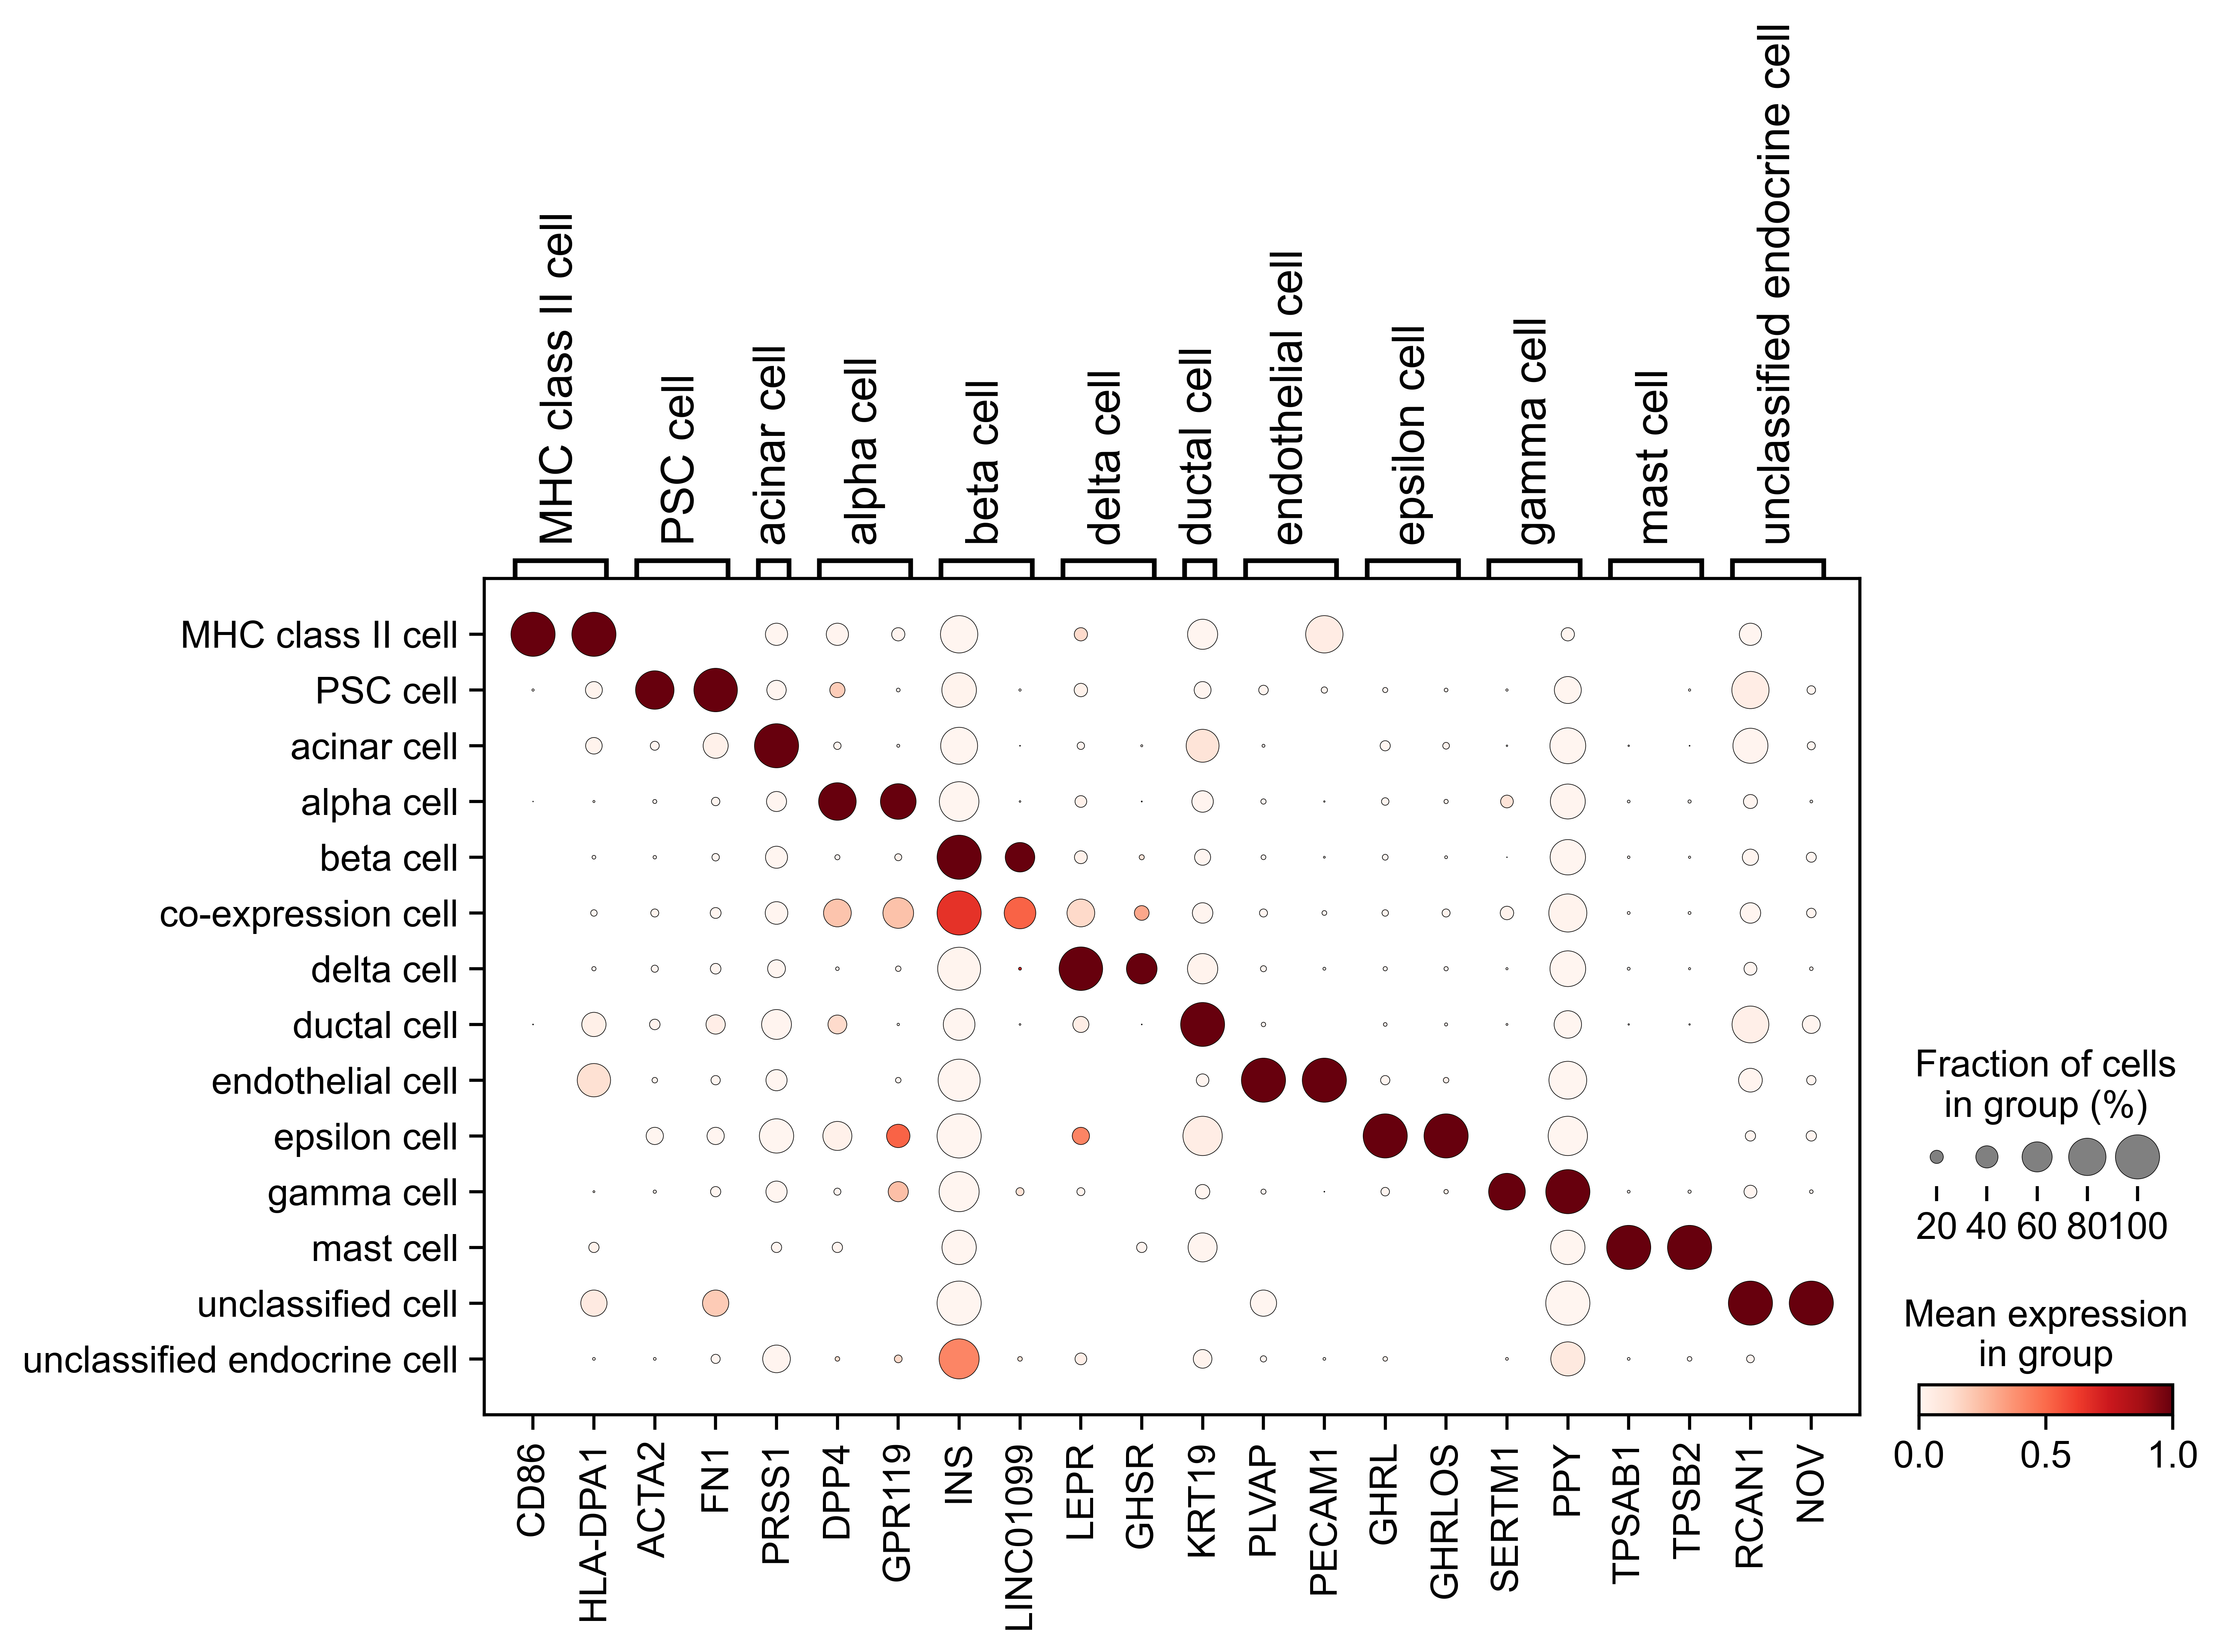

In [30]:
sc.pl.dotplot(pan_result['Prebinary'], pan_markers, groupby='Cell_Type', standard_scale='var', save=f'{prefix}pan_celltype.svg')

/usr/local/Caskroom/miniconda/base/envs/muon_compat/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


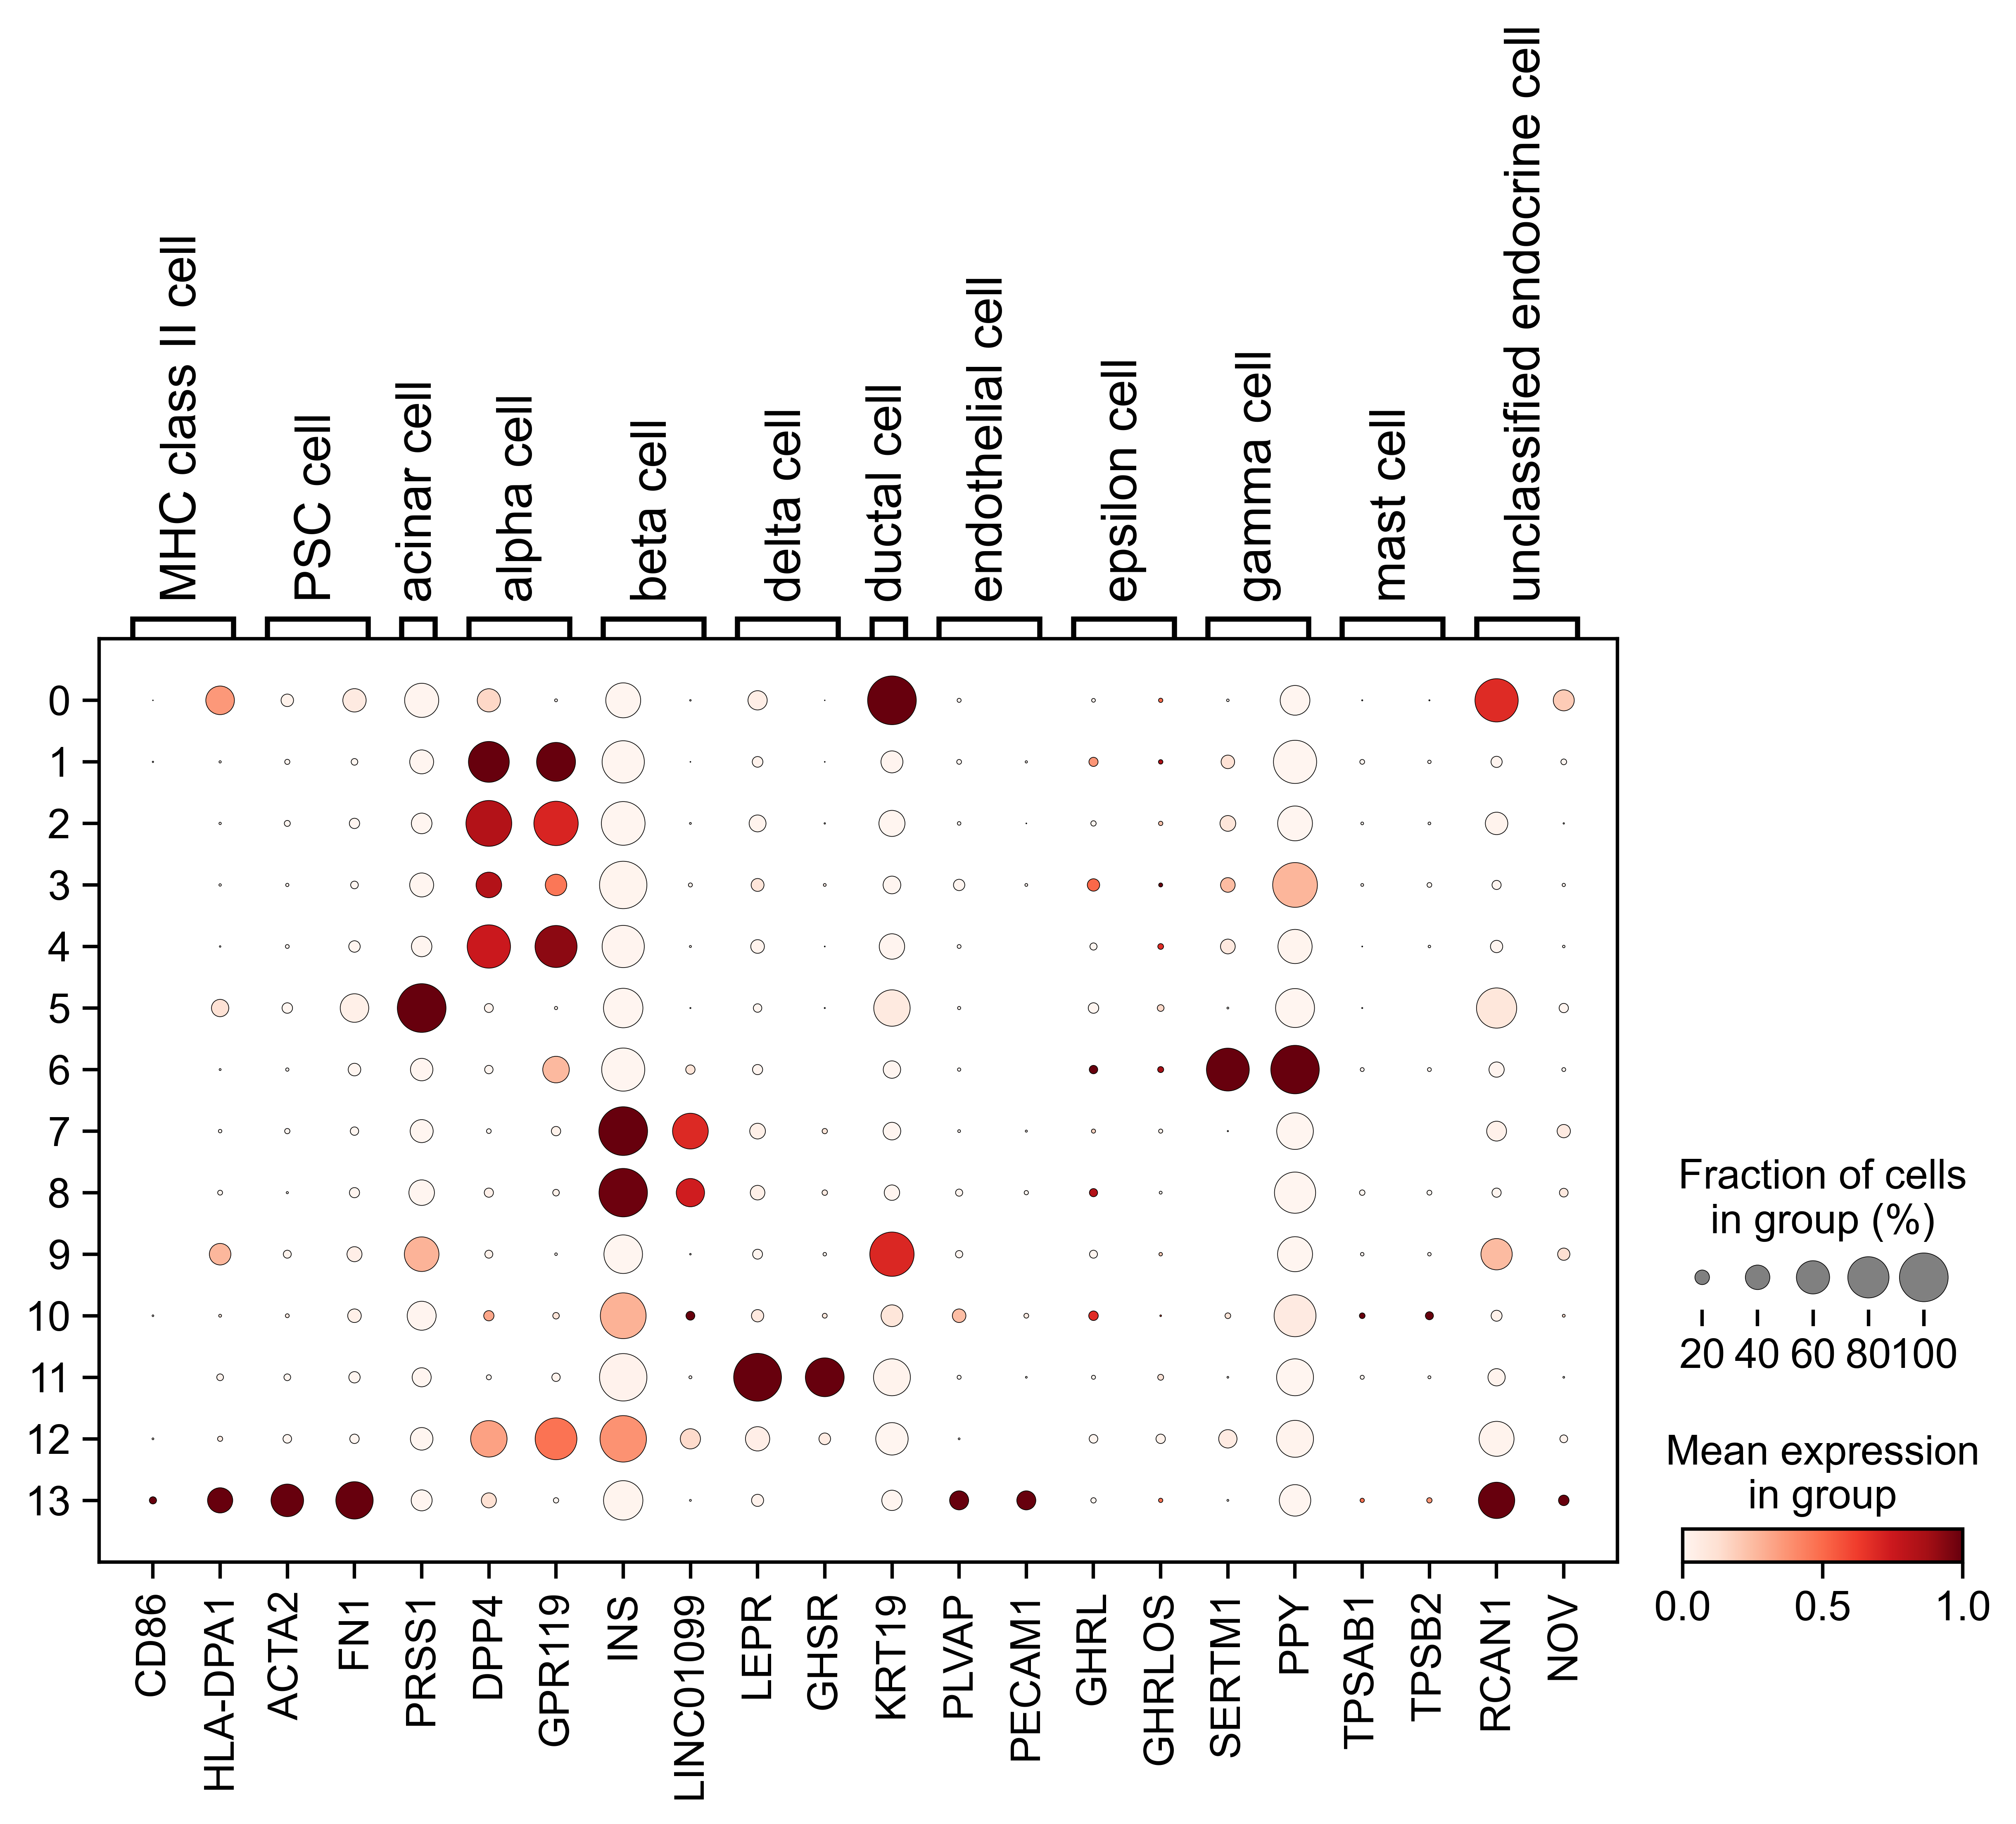

In [31]:
sc.pl.dotplot(pan_result['Prebinary'], pan_markers, groupby='Binary_cluster', standard_scale='var', save=f'{prefix}e.svg')

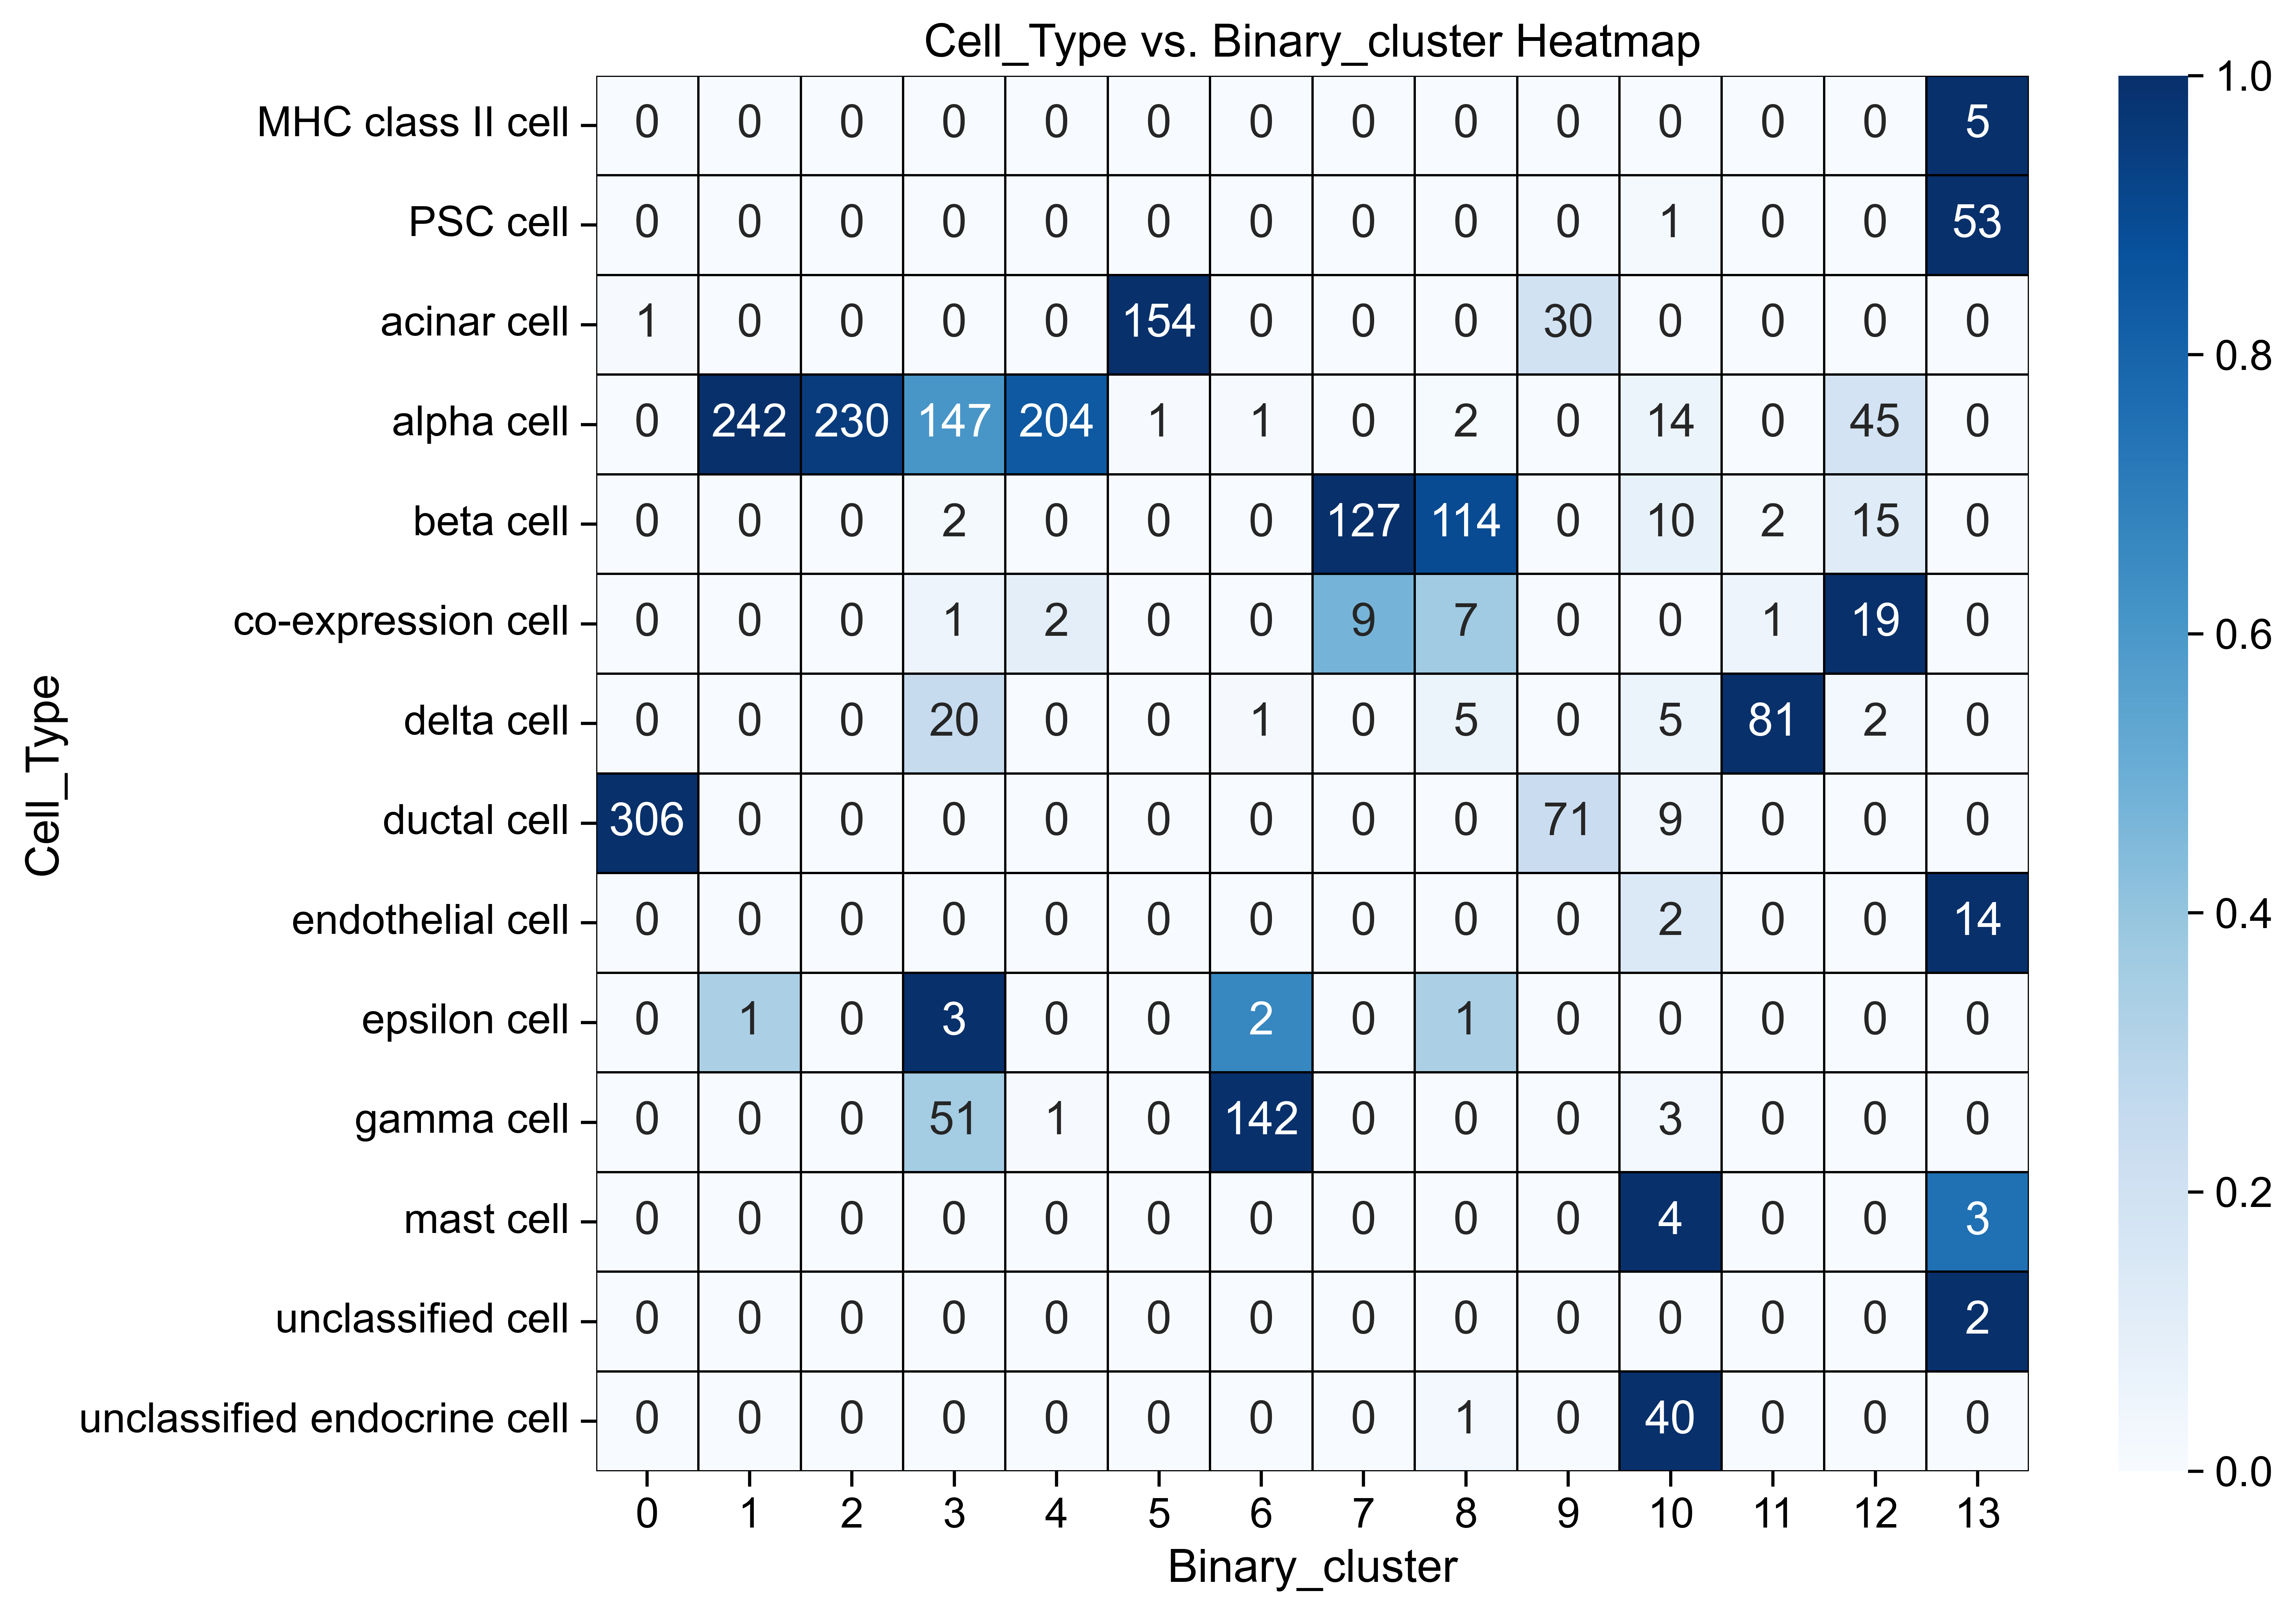

In [44]:
pan_heatmap_fig = create_annotated_heatmap(pan_result['Binary'].obs, 'Cell_Type', 'Binary_cluster')

In [45]:
pan_heatmap_fig.get_figure().savefig(f'{figdir}{prefix}f.svg', dpi=300, bbox_inches='tight')

In [34]:
pan_pd = pan_result['Binary'].obs[['Cell_Type', 'Binary_cluster']]

Alluvial plots in R via rpy2

In [35]:
%%R -i pan_pd

library(tidyverse)
library(ggalluvial)

alluvialplot <- function(labelsdf, repel, nudge_x, ggfittext, ...){


  if( missing(repel) ){ repel = T}
  if( missing(nudge_x) ){nudge_x = 0.3}

  if( missing(ggfittext) ){ggfittext = F}


  #if levels not set, get them by ordering hi > lo

  labelsdf2 <- lapply(labelsdf, function(i){
    if( !is.factor(i) ){
      factor(i, levels = names(sort(table(i),decreasing = T)))
    } else{
      i
    }
  })

  labelsdf <- data.frame(labelsdf2, row.names = rownames(labelsdf))

  require(ggalluvial)

  #for ease, we'll set colnames to from and to
  # colnames(labelsdf)[1:2] <- c('From', 'To')
  # do this with .data trick now to keep colname!


  # turn it into a matrix
  mat <- table(labelsdf[,1], labelsdf[,2])


  #make the table long format
  longfreqs <- reshape2::melt(mat)
  colnames(longfreqs) <- c(colnames(labelsdf)[1:2], 'Freq')


  #factorize, using input levels or existing levels
  # inputting levels is mostly about order.


  longfreqs[,1] <- factor(longfreqs[,1], levels = levels(labelsdf[,1]) )
  longfreqs[,2] <- factor(longfreqs[,2], levels = levels(labelsdf[,2]))
  longfreqs[,3] <- factor(longfreqs[,3])

  #if both are numerics, it seems to cause an issue, so convert to char vector...
  # if(is.numeric(longfreqs)[1] & is.numeric(longfreqs)[2])
  # can't reporduce that problem...


  if(ggfittext == T){

    require(ggfittext)
    ap <- ggplot(longfreqs, aes(y = Freq, axis1=.data[[colnames(longfreqs[1])]], axis2= .data[[colnames(longfreqs[2])]] ))+
      geom_alluvium(aes(fill= .data[[colnames(longfreqs[1])]] )) +
      geom_stratum()+
      #geom_label(stat = "stratum", aes(label = after_stat(stratum)))+
      ggfittext::geom_fit_text(stat = "stratum",aes(label = after_stat(stratum)), width = 1/4, min.size = 3) +
      theme_void()


  } else if(repel==T){

    require(ggrepel)

    ap <- ggplot(longfreqs, aes(y = Freq, axis1=.data[[colnames(longfreqs[1])]], axis2= .data[[colnames(longfreqs[2])]] ) )+
      scale_x_discrete(expand = c(0.2, 0)) +
      geom_alluvium( aes(fill= .data[[colnames(longfreqs[1])]] ), width = 0.2 ) +
      geom_stratum(width = 0.2) +
      scale_linetype_manual(values = c("blank", "solid")) +

      ggrepel::geom_label_repel(
        aes(label = .data[[colnames(longfreqs[1])]] ),
        stat = "stratum", nudge_x = nudge_x * -1, ...) +

      ggrepel::geom_label_repel(
        aes(label = .data[[colnames(longfreqs[2])]]),
        stat = "stratum", nudge_x = nudge_x, ...) +
      theme_void()

  } else{

    ap <- ggplot(longfreqs, aes(y = Freq, axis1=.data[[colnames(longfreqs[1])]], axis2= .data[[colnames(longfreqs[2])]] ) )+
      geom_alluvium(aes(fill= .data[[colnames(longfreqs[1])]] )) +
      geom_stratum()+
      geom_label(stat = "stratum", aes(label = after_stat(stratum)))+
      # ggfittext::geom_fit_text(stat = "stratum",aes(label = after_stat(stratum)), width = 1/4, min.size = 3) +
      theme_void()


  }
  ap

}

alluvialplot(pan_pd, repel=T, nudge_x=0.3, ggfittext=F)#, dpi=300, height=15, width=30)
ggsave('figure_S2/S2_pan_alluvial.svg', dpi=300, height=10, width=10)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


R[write to console]: Loading required package: ggrepel

